In [1]:
import tensorflow as tf
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import Model
from tensorflow.keras import layers
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

import numpy as np 
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import nltk
import re

import pennylane as qml
from pennylane import numpy as p_np
from pennylane.templates.state_preparations import MottonenStatePreparation
from pennylane.templates.layers import StronglyEntanglingLayers

from nltk.corpus import stopwords
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

import nltk
nltk.download('stopwords')



[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\MITHUN\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [2]:
data = pd.read_csv("tweet_emotions.csv")
plt.style.use('fivethirtyeight')

<Axes: xlabel='count', ylabel='sentiment'>

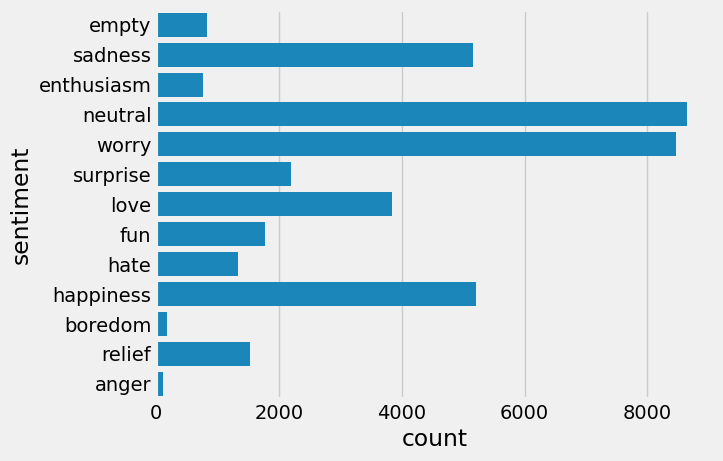

In [3]:
sns.countplot(y=data["sentiment"])

In [4]:
stop_words = set(stopwords.words('english'))
from nltk.stem import RegexpStemmer
snowball = RegexpStemmer('ing$|s$|e$|able$', min=4)

data["content"] = data["content"].apply(lambda x: " ".join([snowball.stem(re.sub(r'[^\w\d]', "", word)) for word in x.lower().split() if word not in stop_words]))

X = data["content"]
tokenize = Tokenizer()

tokenize.fit_on_texts(X)

max_length = 64
vocab_size = len(tokenize.word_index) + 1
X = pad_sequences(tokenize.texts_to_sequences(X), maxlen=max_length, padding="post")

In [5]:
n_qubits = 2
dev = qml.device("default.qubit", wires=n_qubits)

@qml.qnode(dev)
def qnode(inputs, weights):
    qml.templates.AngleEmbedding(inputs, wires=range(n_qubits))
    qml.templates.StronglyEntanglingLayers(weights, wires=range(n_qubits))
    return qml.expval(qml.PauliZ(0)), qml.expval(qml.PauliZ(1))

weight_shapes = {"weights": (3, n_qubits, 3)}

qlayer = qml.qnn.KerasLayer(qnode, weight_shapes, output_dim=2)
clayer1 = tf.keras.layers.Dense(2)
clayer2 = tf.keras.layers.Dense(13, activation="softmax")
model = tf.keras.models.Sequential([clayer1, qlayer, clayer2])
opt = tf.keras.optimizers.SGD(learning_rate=0.8)
model.compile(opt, loss='mae')

c:\Users\MITHUN\AppData\Local\Programs\Python\Python312\Lib\site-packages\pennylane\qnn\keras.py:317: PennyLaneDeprecationWarning: The 'KerasLayer' class is deprecated and will be removed in v0.42. 
  warnings.warn(


In [6]:
Y = data['sentiment']

func = LabelEncoder()

Y = func.fit_transform(Y)
Y = tf.convert_to_tensor(Y)

X = tf.constant(X)
Y = tf.one_hot(Y, depth=1)

In [7]:
model.fit(X,Y, epochs=1, batch_size=256, shuffle=True,steps_per_epoch=1,validation_split=0.1)

1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step - loss: 0.0802 - val_loss: 0.0773


In [36]:
a = "Yes, I love this movie "
tokenize.fit_on_texts(a)

max_length = 64
vocab_size = len(tokenize.word_index) + 1
a = pad_sequences(tokenize.texts_to_sequences(a), maxlen=max_length, padding="post")

In [37]:
a = tf.constant(a)
prediction = model.predict(a)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


In [38]:
ap = []
for i in range(len(prediction)):
    ap.append(np.argmax(prediction[i]))
np.argmax(ap)

2

In [39]:
result = np.argmax(ap)
result = np.array(result).reshape(1)

In [40]:
func.inverse_transform(result)

array(['empty'], dtype=object)

In [41]:
model.save("quantum_emotion_model.h5")
